In [32]:
# import the necessary packages
import timeit
import matplotlib.pyplot as plt
import cv2
import pickle
import time as t
import cython
import skimage
import numpy as np
from scipy.spatial import distance
from skimage import morphology, img_as_bool, img_as_int
from PIL import Image
from tqdm import tqdm
import helper
%matplotlib inline

In [2]:
%load_ext cython

# Function Defs

In [54]:
def get_points(img):
    """
    Gets the four points of the four corner points 
    of the border edges and uses the fact that the 
    image is a closed convex set and thus extrema 
    will occur at corner points.
    
    Parameters
    ----------
    input: image represented as np array
    
    output: the coordinates of the 4 corner points
    """
    
    
    im = img_as_int(img).astype('int16')
    actv_lst = get_ones_fast(im)
    
    p2 = min(actv_lst)
    p4 = max(actv_lst)
    
    
    colorImage  = Image.fromarray(im)
    transposed  = colorImage.transpose(Image.ROTATE_90)
    rotated = np.array(transposed)
    rotated = img_as_int(rotated)
    other_lst = get_ones_fast(rotated)
    
    p1 = max(other_lst)
    p1 = switch_pair(p1,img)
    
    p3 = min(other_lst)
    p3 = switch_pair(p3,img)
    
    print(p1,p2,p3,p4)
    return p1,p2,p3,p4

In [55]:
def getEquidistantPoints(p1, p2, step_size):
    x_vals = np.linspace(p1[0], p2[0], step_size+1)
    y_vals = np.linspace(p1[1], p2[1], step_size+1)
    line = zip(x_vals,y_vals)
    return line

In [56]:
def remove_stuff(img, pts_arr):
    """
    This function will set the pixels with coordinates in the pts_arr to 0.
   
    Params
    -----------------
    input: img - np array representing an image
           pts_arr - an array of coordinate points to be set to 0
          
    output: img with specified pixels set to 0
    """
    for i, pts in enumerate(pts_arr):
        
        # a bunch of try statements in case we go out of bounds no exceptions are thrown
        
        try: img[pts[0]][pts[1]] = 0
        except: continue
        try: img[pts[0]-1][pts[1]-1] = 0
        except: continue                
        try:img[pts[0]-2][pts[1]-2] = 0
        except: continue
        try: img[pts[0]+1][pts[1]+1] = 0
        except: continue
        try:img[pts[0]+2][pts[1]+2] = 0
        except: continue
            
                
    return img

In [57]:
def remove_check(img, pts_arr):
    """
    Static function that checks how many pixels would be 
    changed if we make the remove_stuff() call
    """
    # init count vars
    changed = 0
    not_changed = 0
    
    for i, pts in enumerate(pts_arr):
        #print('the first coor: ' + str(pts[0]) + ' and the second ' + str(pts[1]))
        if (img[pts[0]][pts[1]] > 0 or img[pts[0]-1][pts[1]-1] > 0 or img[pts[0]-2][pts[1]-2] > 0 or img[pts[0]+1][pts[1]+1] > 0 or img[pts[0]+2][pts[1]+2] > 0 ):
            changed+=1
        else:
            not_changed+=1
                
    print(str(changed) + ' pixels changed and ' + str(not_changed) + ' were not changed')

In [58]:
%%cython 

cpdef short [:, :] remove_act_pix(short [:, :] image, short [:,:] pts_lst):
   
    # declare variables
    cdef int x, y, w, h
    
    # initialize variables
    h = image.shape[0]
    w = image.shape[1]
    
    # loop over the image
    for y in range(0, h): 
        for x in range(0, w):
            # if pixel is in remove list then remove
            if((y,x) in pts_lst):
                image[y][x] = 0
    #print('Current y val: ' + str(y))          
    
    # return the list of activated pixels image
    return image

In [59]:
def switch_pair(point, img):
    """
    Translates the observed coordinates in the rotated image
    back to the basis of the non-rotated image
    
    Params
    -----------------
    input: point - the ordered pair to be switched
    
           img - a np array representing an image
 
    """
    
    return (point[1],(img.shape[1]-1)- point[0])

In [60]:
%%cython 

cpdef list get_ones_fast(short [:, :] image):
    # declare variables
    cdef int x, y, w, h
    cdef list ones
    
    # initialize variables
    h = image.shape[0]
    w = image.shape[1]
    ones = []
    
    # loop over the image
    for y in range(h): 
        for x in range(w):
            # if pixel is 'activated' save it to list
            if(image[y,x] > 0):
                ones.append((y,x +1))
                
    
    # return the list of activated pixels image
    return ones

In [61]:
def get_line(p1,p2,step_size):
    pts = getEquidistantPoints(p1, p2, step_size)
    pts_lst = list(pts)
    pts_arr = np.asarray(pts_lst, dtype='int16')
    return pts_arr 

In [62]:
def get_distance(img):
    p1, p2, p3, p4 = get_points(img.astype('int16'))

    # Get distance rounded down to the nearest int
    dist_1 = distance.euclidean(p1, p2)
    dist_1 = np.floor(dist_1).astype('int')

    dist_2 = distance.euclidean(p2, p3)
    dist_2 = np.floor(dist_2).astype('int')

    dist_3 = distance.euclidean(p3, p4)
    dist_3 = np.floor(dist_3).astype('int')

    dist_4 = distance.euclidean(p4, p1)
    dist_4 = np.floor(dist_4).astype('int')

    return (dist_1, dist_2,dist_3, dist_4)

In [74]:
def remove_borders(img, Lines):
    for line in Lines:
        img = remove_stuff(img, line)
    inverse = img_as_bool(img)
    morph = morphology.remove_small_objects(inverse, min_size=100000)
    
    return morph

In [64]:
def get_line_arr(distances, points):
    lines=[]
    for i, pts in enumerate(points):
        if i<3:
            #not yet on last line
            lines.append(get_line(pts, points[i+1], distances[i]))
        else:
            # last line
            lines.append(get_line(pts, points[i-3], distances[i]))                
        
    return lines 

In [67]:
pts = get_points(img)
dst = get_distance(img)

/home/zbarnes/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int32 to int16 without scaling because max value 32767 fits in int16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


(12095, 18) (22, 4923) (4817, 16768) (16880, 11939)


/home/zbarnes/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int32 to int16 without scaling because max value 1 fits in int16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


(12095, 18) (22, 4923) (4817, 16768) (16880, 11939)


In [79]:
bleg = get_line_arr(dst, pts)
bleg

[array([[12095,    18],
        [12094,    18],
        [12093,    18],
        ...,
        [   23,  4922],
        [   22,  4922],
        [   22,  4923]], dtype=int16), array([[   22,  4923],
        [   22,  4923],
        [   22,  4924],
        ...,
        [ 4816, 16766],
        [ 4816, 16767],
        [ 4817, 16768]], dtype=int16), array([[ 4817, 16768],
        [ 4817, 16767],
        [ 4818, 16767],
        ...,
        [16878, 11939],
        [16879, 11939],
        [16880, 11939]], dtype=int16), array([[16880, 11939],
        [16879, 11938],
        [16879, 11937],
        ...,
        [12095,    19],
        [12095,    18],
        [12095,    18]], dtype=int16)]

# Load Image

<Figure size 432x288 with 0 Axes>

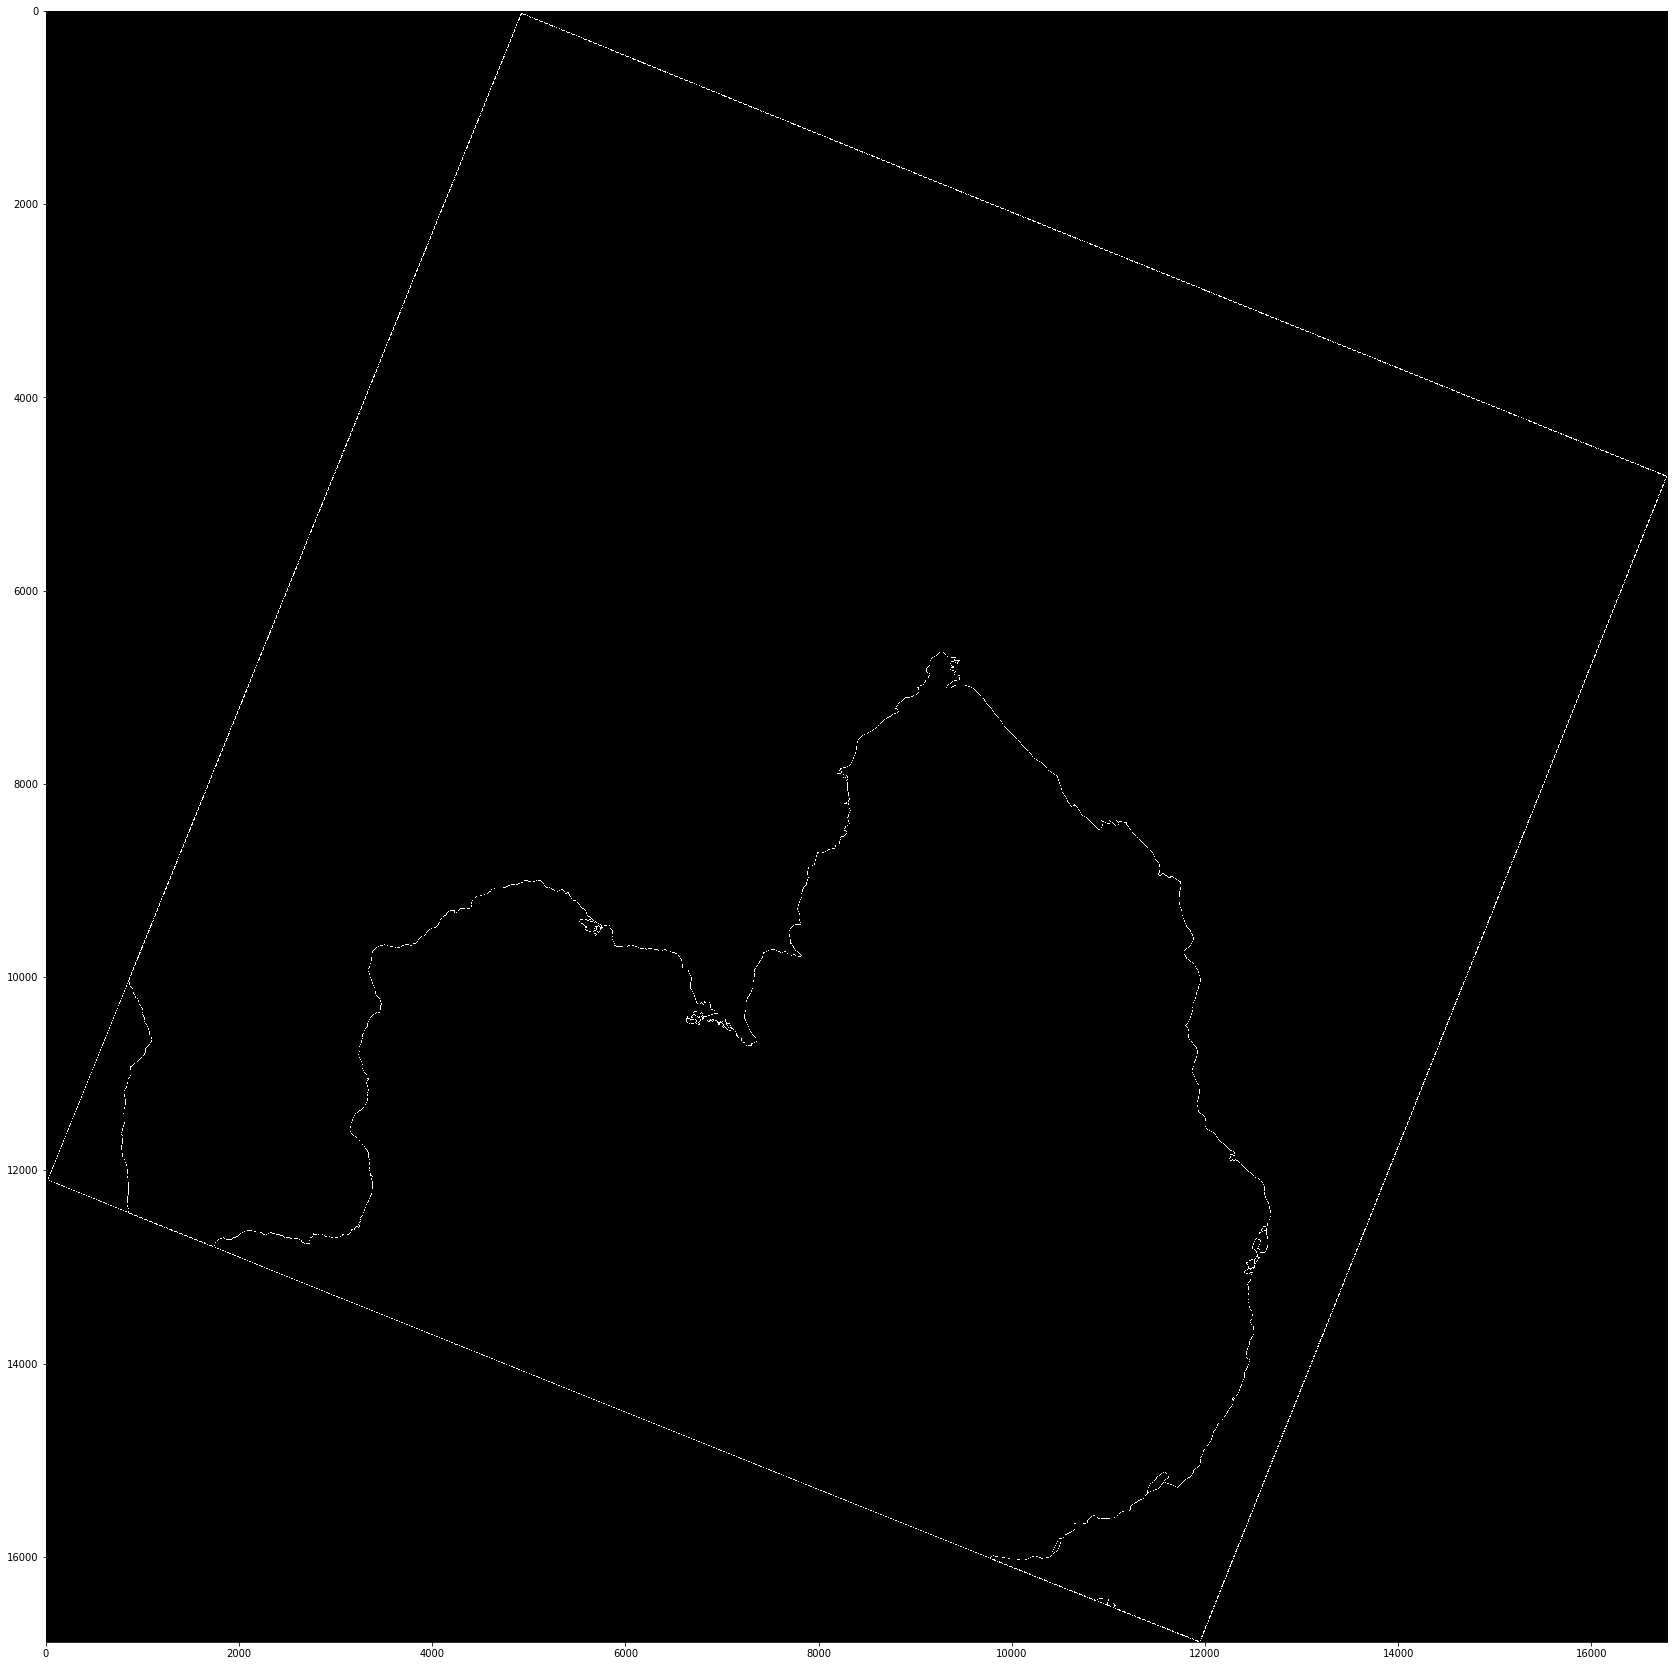

In [43]:
with open('seg_pic', 'rb') as f:
    img = pickle.load(f)
plt.gray()
plt.figure(figsize=(30,30))
plt.imshow(img)

## Make sure image is saved as int and get activated pixels

In [118]:
img = img_as_int(img).astype('int16')
#img =img/max(img)
#cpdef short img = <short> img
img = img/np.max(img)
#ones = get_ones_fast(img)
img = img_as_int(img).astype('int16')

/home/zbarnes/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to int16
  .format(dtypeobj_in, dtypeobj_out))


In [119]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

## Get corner points and distance between

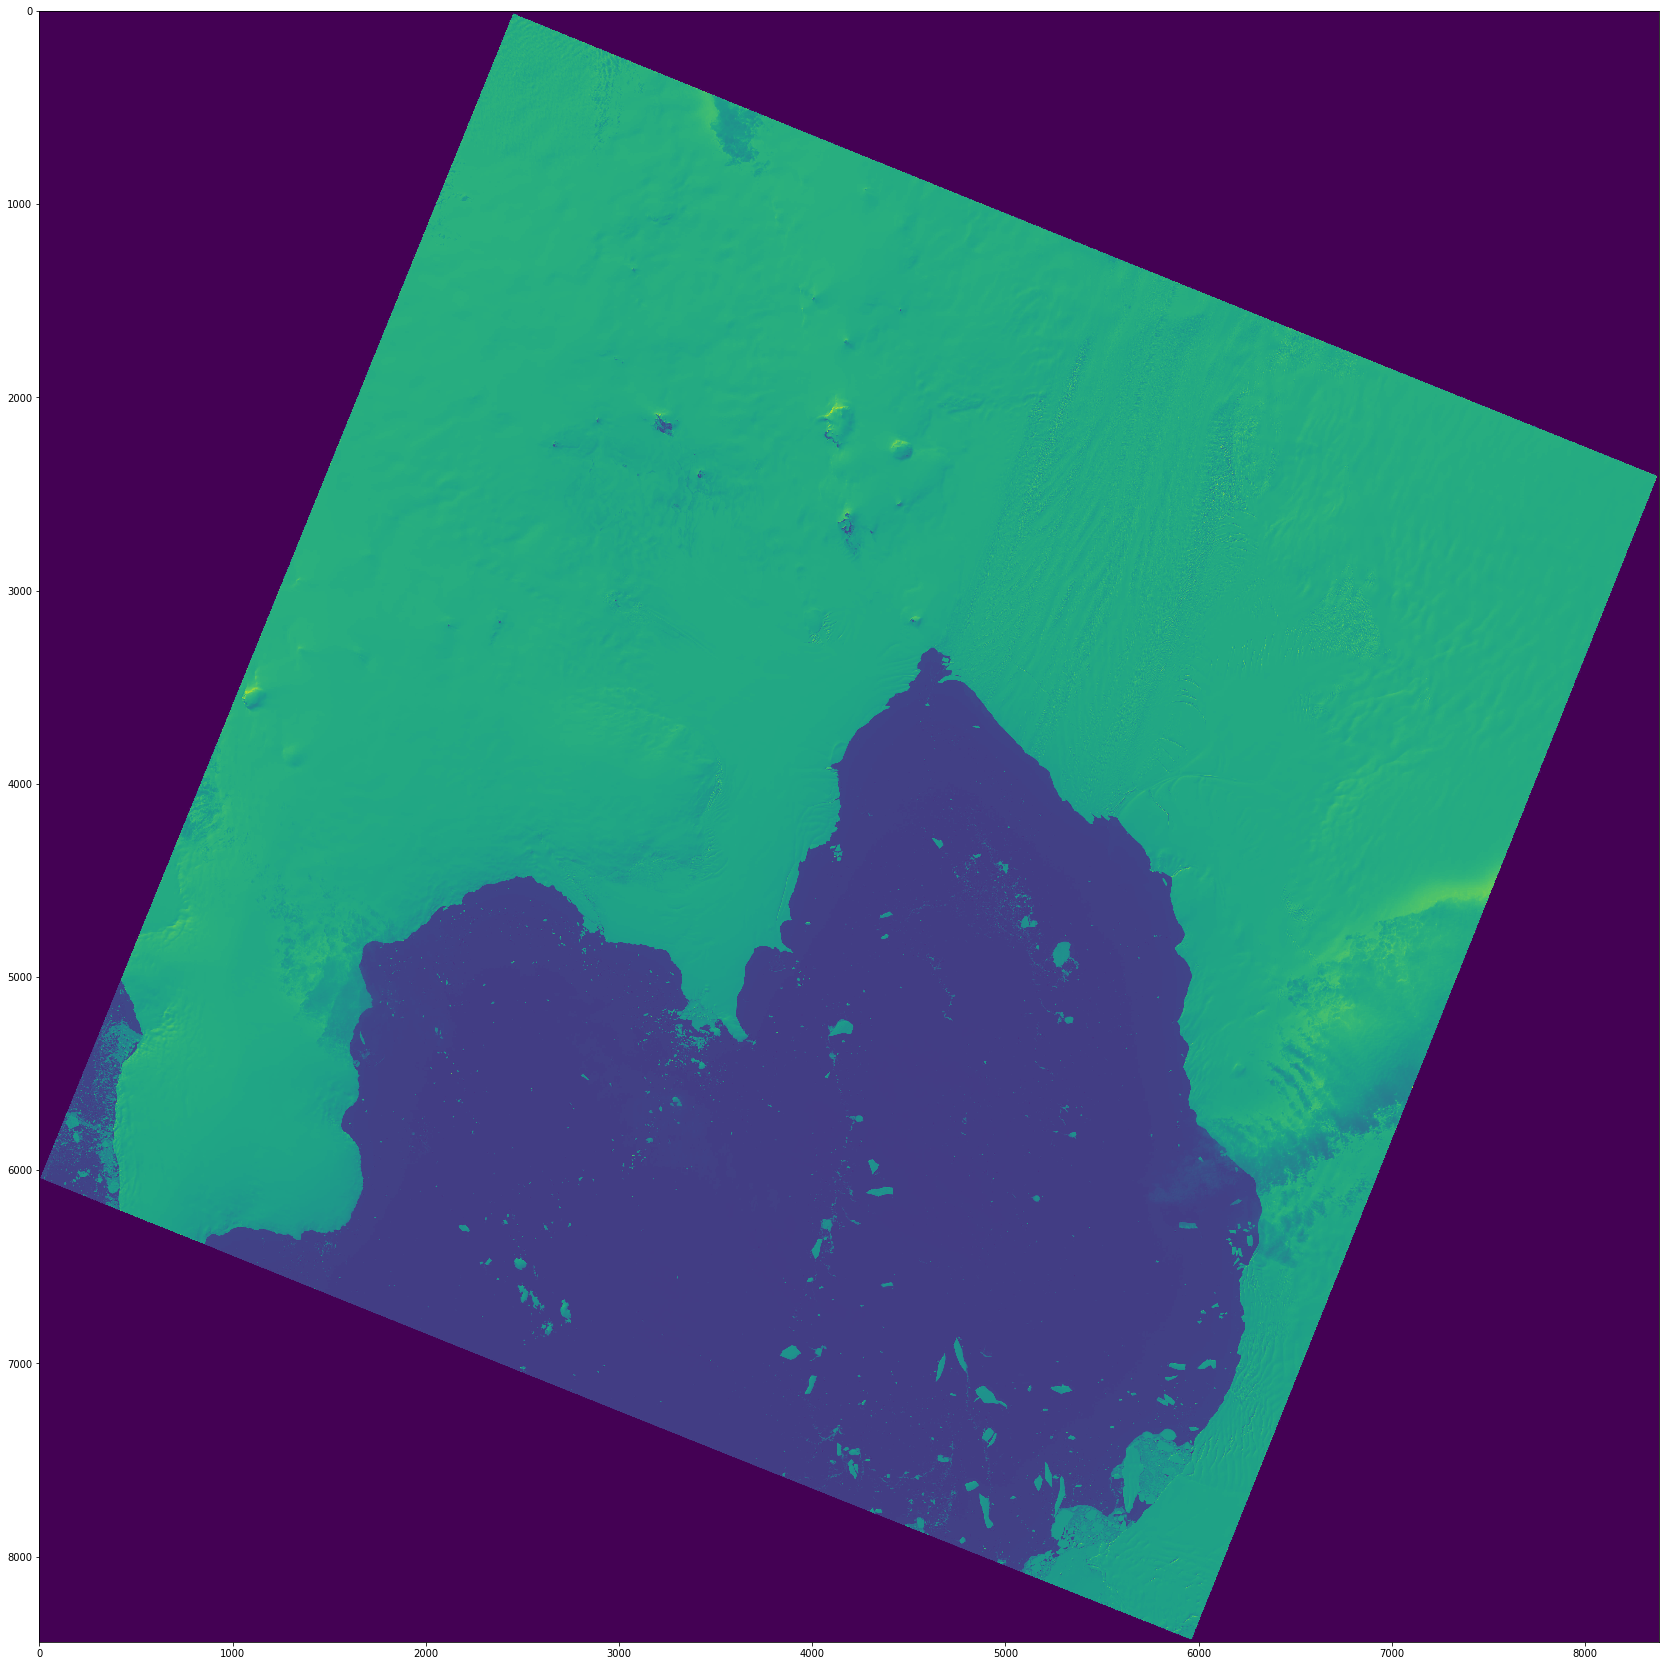

In [38]:
im = plt.imread('my.jpeg')
plt.figure(figsize=(30,30))
plt.imshow(im)
flt_im = helper.anisotropic(im, niter=10)

<Figure size 2160x2160 with 0 Axes>

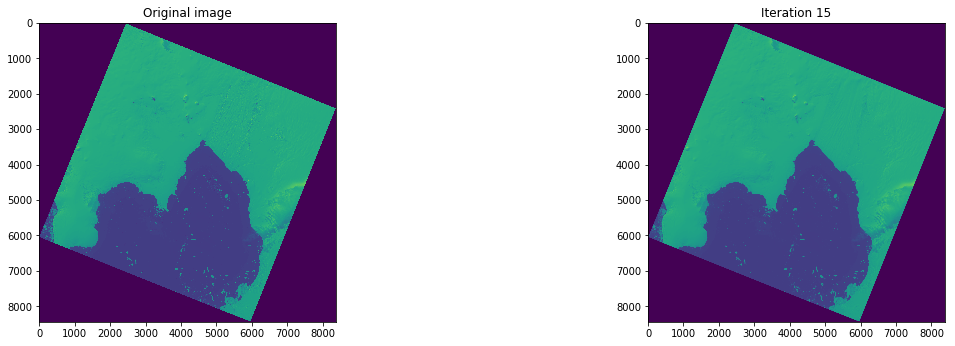

In [10]:
im = plt.imread('my.jpeg')
plt.figure(figsize=(30,30))
#plt.imshow(im)
flt_im = h.anisotropic(im, niter=15,kappa=100,gamma=0.25, ploton=True)

In [69]:
lines = []
line_1 = get_line(pts[0],pts[1],dst[0])
lines.append(line_1)
line_2 = get_line(pts[2],pts[1],dst[1])
lines.append(line_2)
line_3 = get_line(pts[2],pts[3],dst[2])
lines.append(line_3)
line_4 = get_line(pts[0],pts[3],dst[3])
lines.append(line_4)

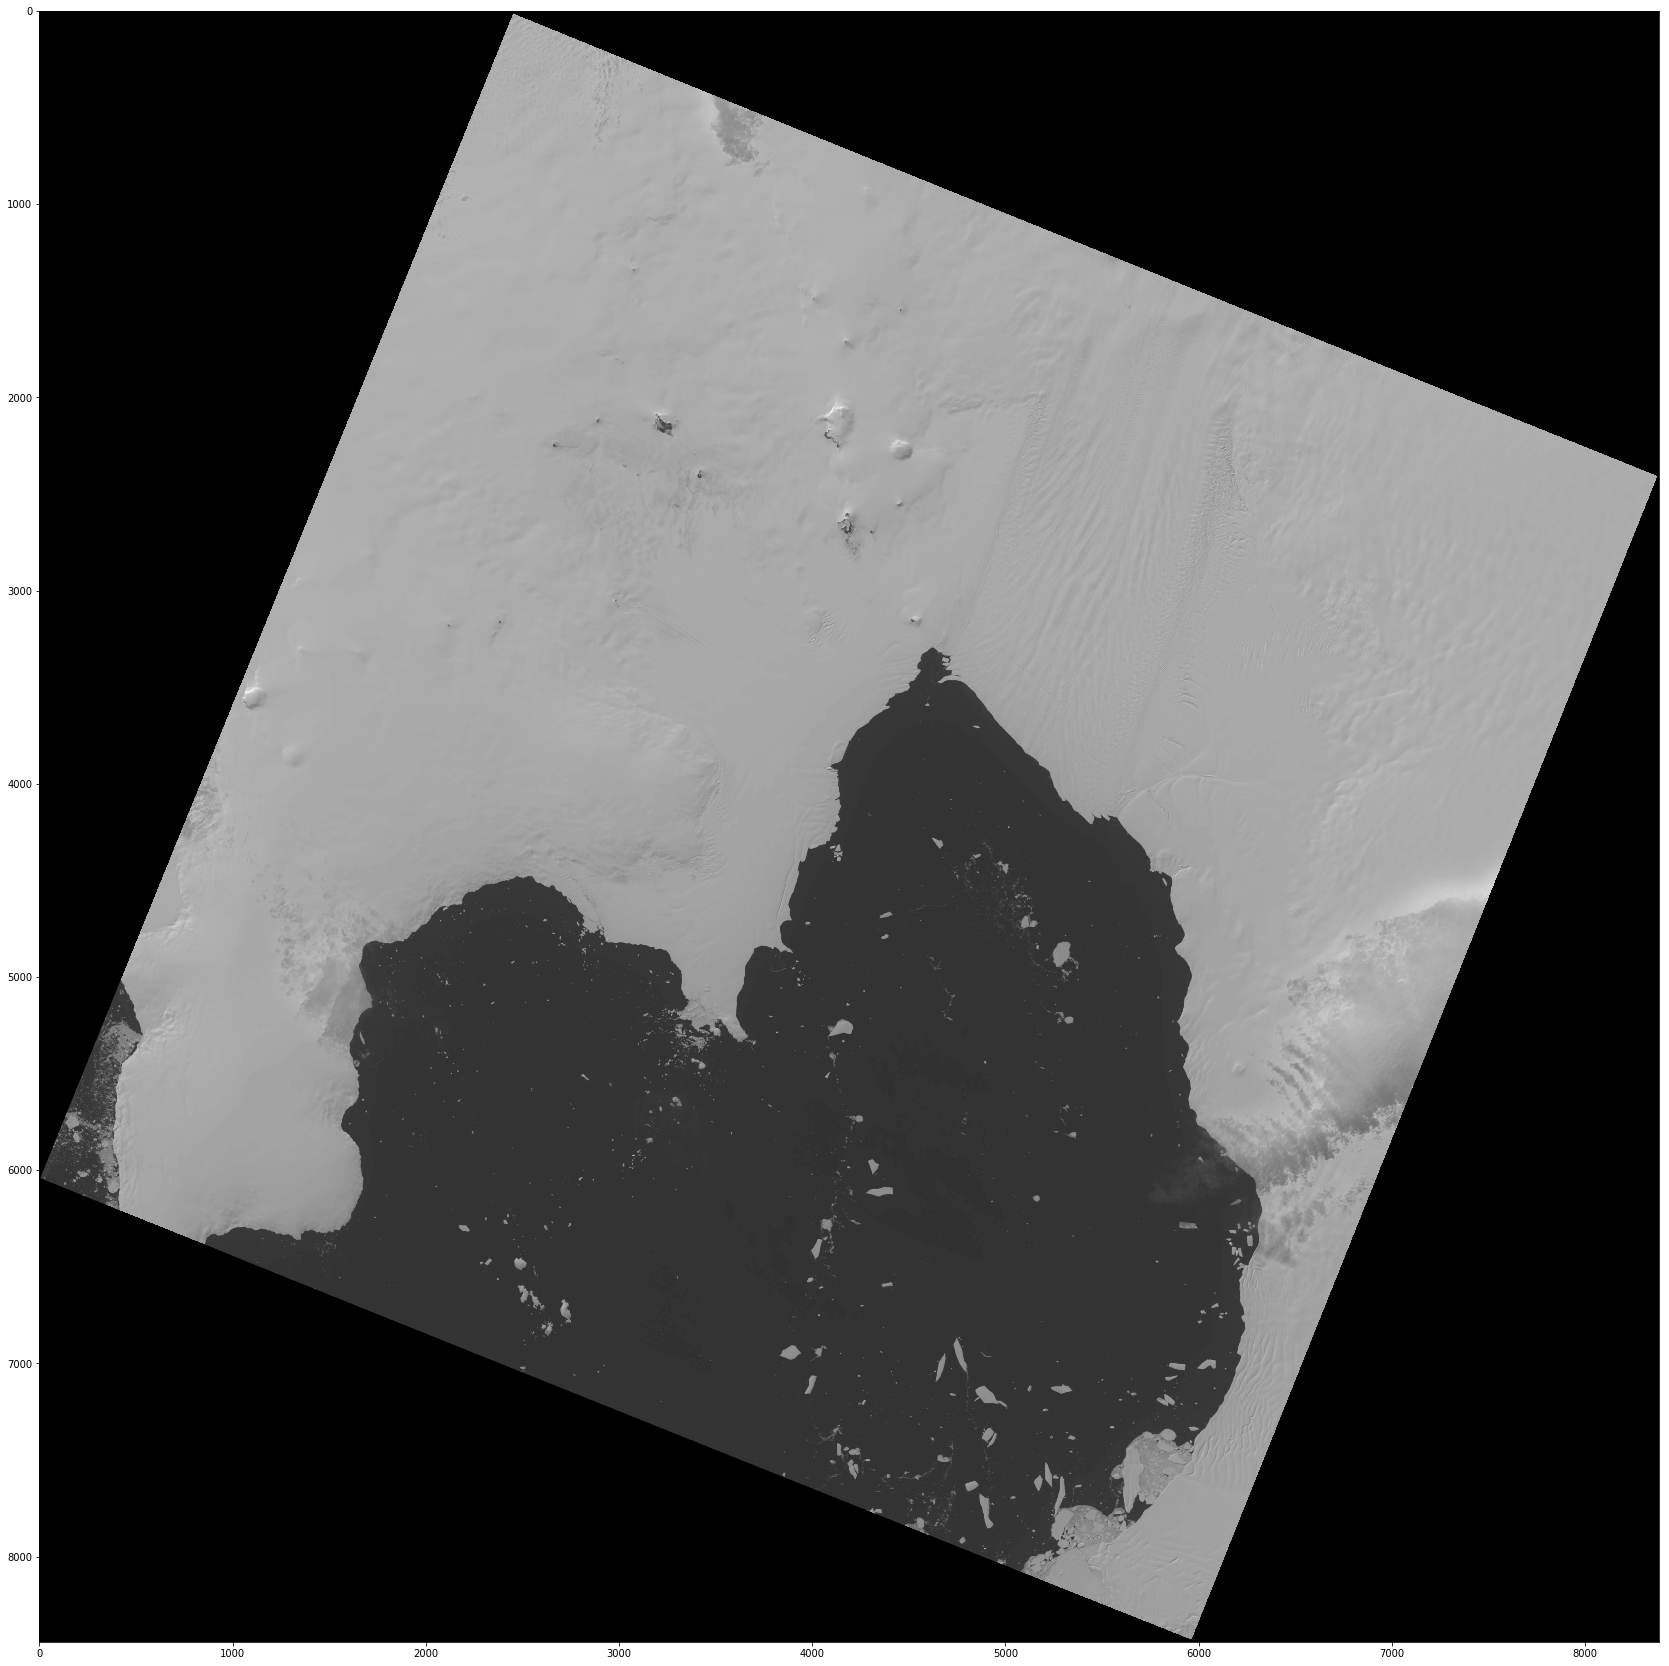

In [112]:
plt.figure(figsize=(30,30))
plt.imshow(flt_im)

(array([2.9154105e+07, 8.7492650e+06, 4.9012660e+06, 1.3516400e+05,
        1.8469300e+05, 1.2005180e+06, 2.5900093e+07, 5.0540100e+05,
        1.2784000e+04, 7.3200000e+02]),
 array([  0.      ,  16.019135,  32.03827 ,  48.057404,  64.07654 ,
         80.09567 ,  96.11481 , 112.13394 , 128.15308 , 144.17221 ,
        160.19135 ], dtype=float32),
 <a list of 10 Patch objects>)

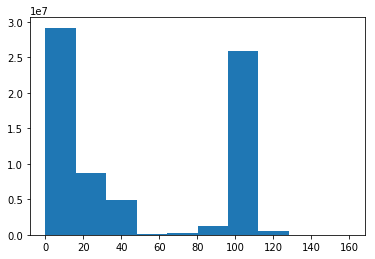

In [113]:
plt.hist(flt_im.flat)

(array([2.9152921e+07, 1.2572321e+07, 1.1269860e+06, 1.0423200e+05,
        4.1891900e+05, 7.7718720e+06, 1.9533459e+07, 6.1731000e+04,
        1.5200000e+03, 6.0000000e+01]),
 array([  0. ,  17.5,  35. ,  52.5,  70. ,  87.5, 105. , 122.5, 140. ,
        157.5, 175. ]),
 <a list of 10 Patch objects>)

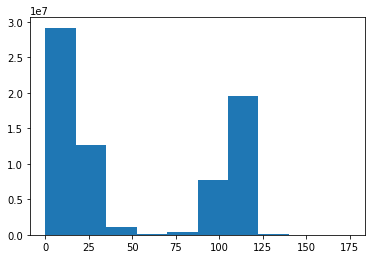

In [114]:
plt.hist(im.flat)

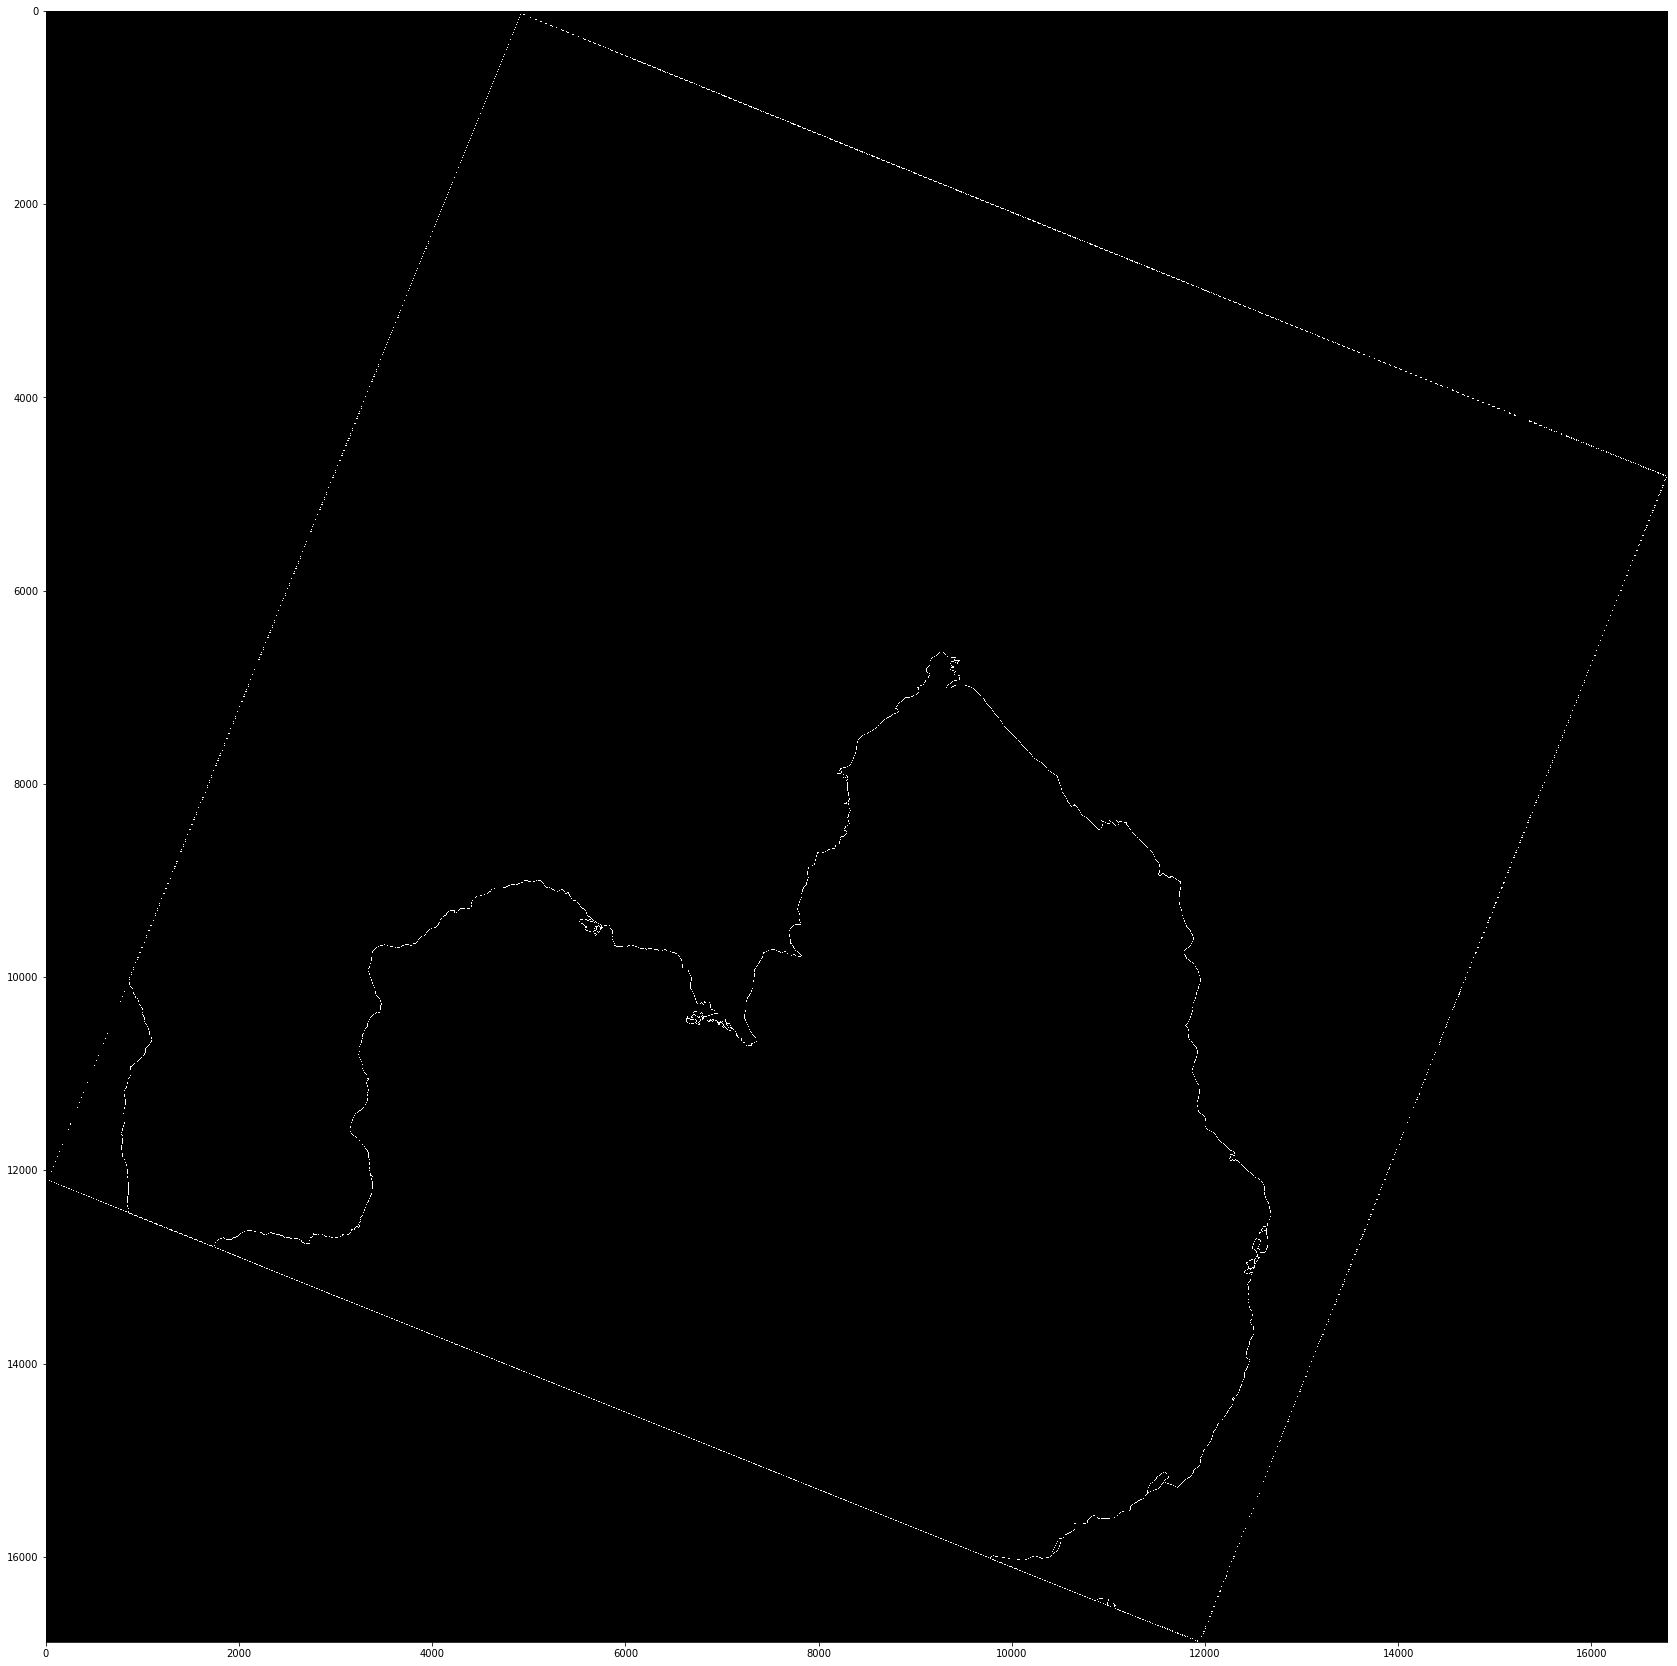

In [98]:
plt.figure(figsize=(30,30))
plt.imshow(img)

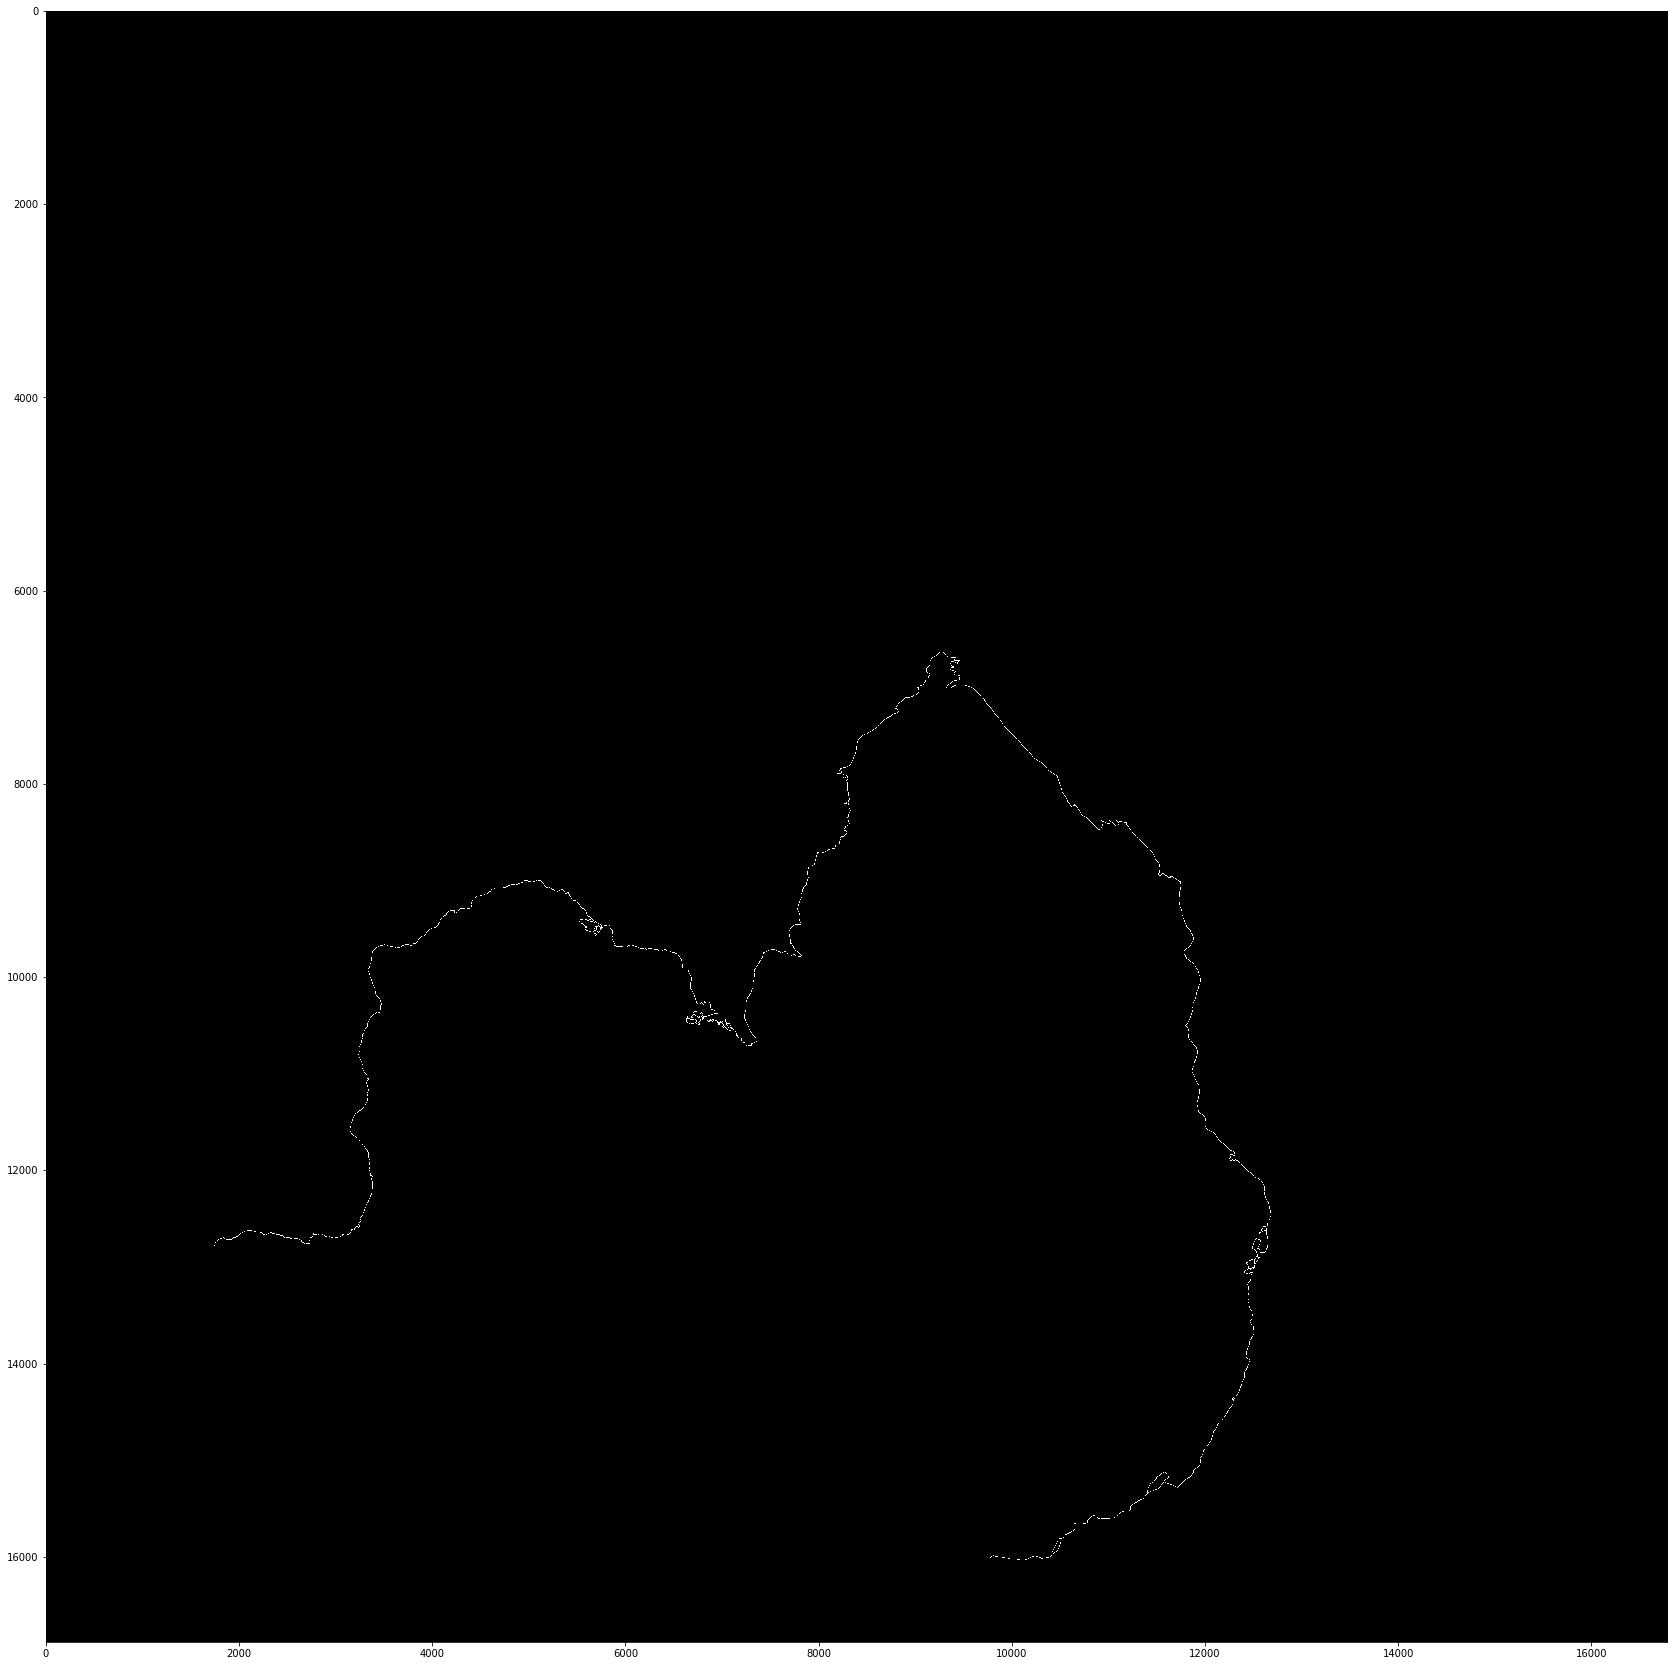

In [75]:
hey=remove_borders(img,lines)
plt.figure(figsize=(30,30))
plt.imshow(hey)

In [62]:
rem_im[12096][19]

0.0

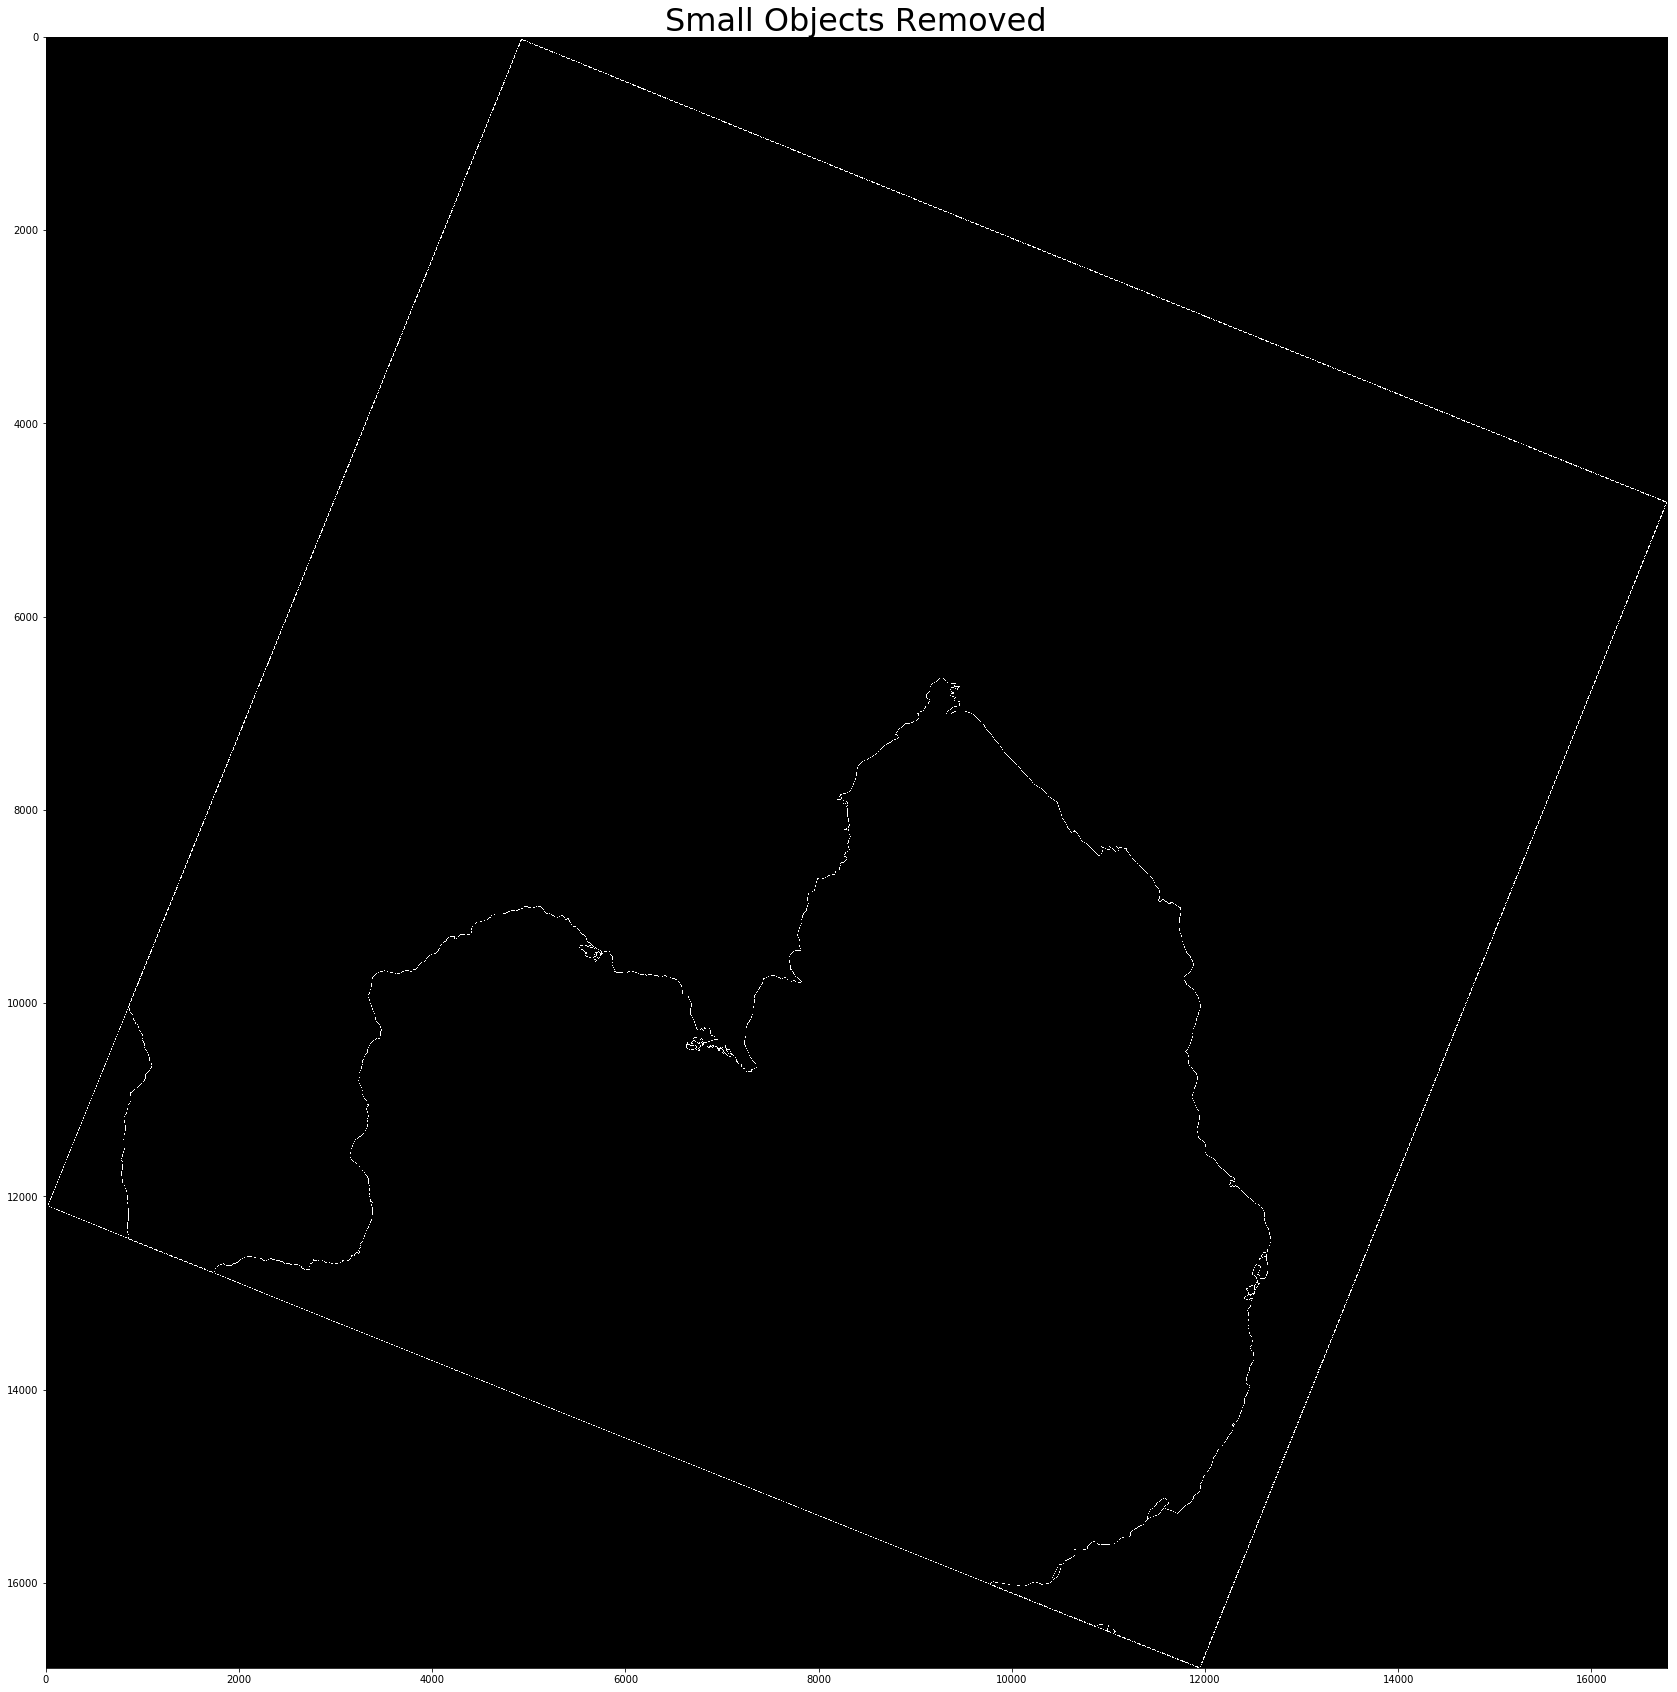

In [52]:
bool_img = img_as_bool(img)
morph = morphology.remove_small_objects(bool_img, min_size=100000)
plt.figure(figsize=(30,30))
plt.gray()
plt.title('Small Objects Removed', fontsize=32)
plt.imshow(morph)

In [76]:
import scipy
#we can run a dialation operator if we want to make the coastline thicker
check = scipy.ndimage.morphology.binary_dilation(hey, iterations=2)

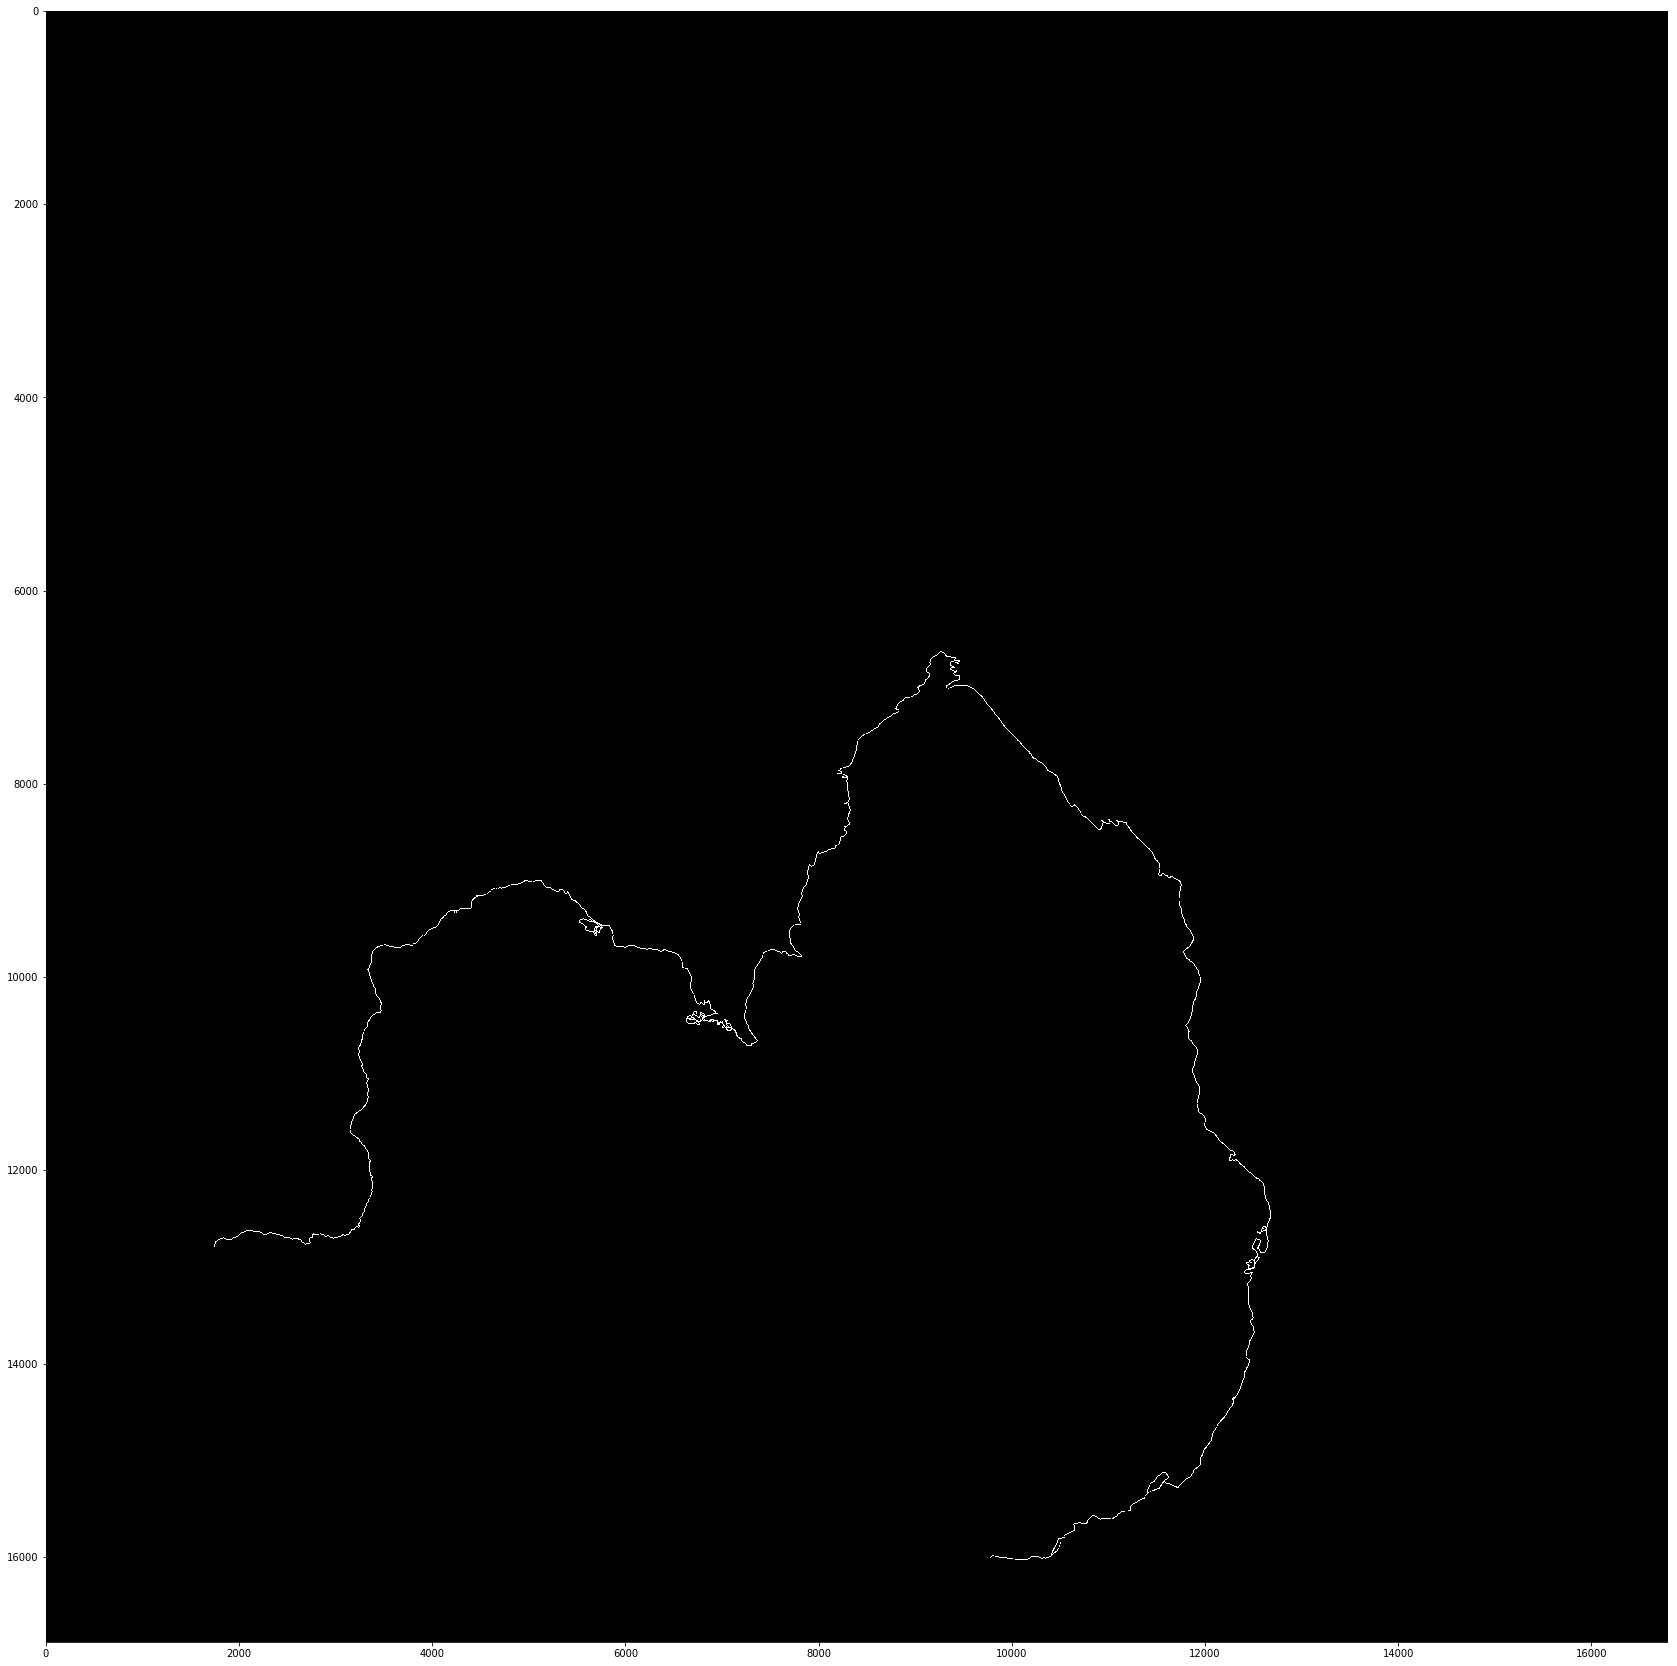

In [77]:
plt.figure(figsize=(30,30))
plt.imshow(check)

In [49]:
#We can now extract a vector of corrdinate points of the coastline
coast_vect = get_ones_fast(check.astype('int16'))

The image dimension are given by the ordered pair, $(height,width), $ where the most northwest corner is $(0,0),$ northeast is given by $(0, width),$ southwest as $(height, 0),$ and finally the southeast corner is given by the image dimensions.

"Oh. East? I thought you said **weast**!"

In [127]:
img.shape

(16881, 16781)

### Taking a look at the histogram below

In [ ]:
img = img_as_int(img)
img = img/np.max(img)
plt.hist(img.flat)